<a href="https://colab.research.google.com/github/alexandertaoadams/AlexanderAdamsMastersThesis/blob/main/NB_MiddlePhalanx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Classification: MiddlePhalanxOutlineCorrect

**URL to original dataset:**  
https://www.timeseriesclassification.com/description.php?Dataset=MiddlePhalanxOutlineCorrect

This notebook trains a **stochastic variational Gaussian Process** on the MiddlePhalanxOutlineCorrect dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install gpjax
!pip install sktime

In [ ]:
# jax libraries
import numpy as np
import jax
import jax.numpy as jnp

# gpjax libraries
import gpjax as gpx

# core libraries
from flax import nnx
import optax as ox

# data manipulation and visualisation libraries
import pandas as pd
from sktime.datasets import load_from_tsfile
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
!git clone https://github.com/alexandertaoadams/AlexanderAdamsMastersThesis.git

import sys
sys.path.insert(0, '/content/AlexanderAdamsMastersThesis')
import AlexanderAdamsMastersThesis.src as src

from src.kernels import SignatureKernel
from src.inducing_variables import initial_inducing_variables
from src.utils import display_parameters, display_results, normalise

In [10]:
def normalise(data, eps=1e-12):
    mean = data.mean(axis=(0), keepdims=True)
    std = data.std(axis=(0), keepdims=True)
    normalised_data = (data - mean) / (std + eps)
    return normalised_data, mean, std

### **Data Loading and Preprocessing**

In [11]:
file_path_train = "/content/drive/MyDrive/DATA_MiddlePhalanxOutlineCorrect/MiddlePhalanxOutlineCorrect_TRAIN.ts"
file_path_test = "/content/drive/MyDrive/DATA_MiddlePhalanxOutlineCorrect/MiddlePhalanxOutlineCorrect_TEST.ts"

train_data, train_labels = load_from_tsfile(file_path_train)
test_data, test_labels = load_from_tsfile(file_path_test)

In [12]:
train_data_2 = jnp.array((np.stack([np.stack(row) for row in train_data.to_numpy()])))
train_labels_2 = jnp.array([int(i) for i in train_labels])
xtrain, train_mean, train_std = normalise(train_data_2)
ytrain = train_labels_2
print(xtrain.shape)
print(ytrain.shape)
print(ytrain)

(600, 1, 80)
(600,)
[1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1
 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0
 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1
 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1
 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1
 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 

In [14]:
test_data_2 = jnp.array((np.stack([np.stack(row) for row in test_data.to_numpy()])))
test_labels_2 = jnp.array([int(i) for i in test_labels])
xtest = ((test_data_2 - train_mean) / (train_std))
ytest = test_labels_2
print(xtest.shape)
print(ytest.shape)
print(ytest)

(291, 1, 80)
(291,)
[0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0
 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1
 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1
 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0
 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0]


### **Model Training**



In [ ]:
# Initialising model
q_kernel = SignatureKernel(xtrain.shape[1], xtrain.shape[2], 3)
q_mean_function = gpx.mean_functions.Constant()
q_prior = gpx.gps.Prior(mean_function=q_mean_function, kernel=q_kernel)
q_likelihood = gpx.likelihoods.Bernoulli(xtrain.shape[0])
q_posterior = q_likelihood * q_prior

# Intialise inducing variables
D = gpx.dataset.Dataset(jnp.reshape(xtrain, (xtrain.shape[0], -1)), jnp.expand_dims(ytrain, axis=1))
Z = initial_inducing_variables(xtrain, ytrain, 32)

# Model
q = gpx.variational_families.VariationalGaussian(
    posterior=q_posterior,
    inducing_inputs=Z
)

In [ ]:
# Training
optimised_model, history = gpx.fit(
    model=q,
    objective= lambda model, data: -gpx.objectives.elbo(model, data),
    train_data=D,
    optim=ox.adam(learning_rate=1e-3),
    trainable=gpx.parameters.Parameter,
    num_iters=2000,
    batch_size=100,
    verbose=True
)

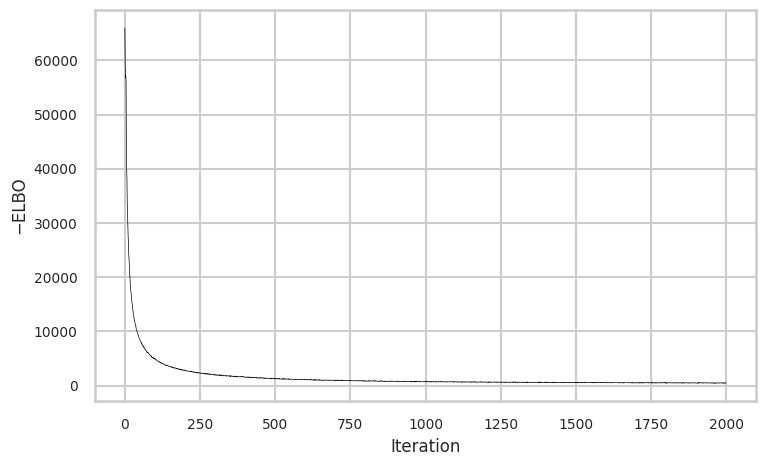

In [17]:
# Plot training process
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(8, 5))
plt.plot(history, color="black", linewidth=0.5, label="Training ELBO")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("−ELBO", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

In [18]:
# Display model hyperparameters
params = display_parameters(optimised_model)
params

,Parameter,Count,Values
0,Lengthscales,1,[1.3022811]
1,Amplitude,1,[1.1008711]
2,Weights,4,"[0.97002745, 1.107678, 1.1108184, 1.0982007]"


### **Model Evaluation**

In [19]:
@jax.jit
def predict_batch(model, batch):
    def predict_single(x):
        latent_dist = model.predict(x[None, :])
        predicted_dist = model.posterior.likelihood(latent_dist)
        return predicted_dist.mean.squeeze()
    return jax.vmap(predict_single)(batch)

def batched_predict(xtest, model, batch_size=90):
    num_points = xtest.shape[0]
    num_batches = (num_points + batch_size - 1) // batch_size

    results = []
    for i in range(num_batches):
        batch = xtest[i * batch_size : (i + 1) * batch_size]
        preds = predict_batch(model, batch)
        results.append(preds)

    return jnp.concatenate(results, axis=0)

In [20]:
# Get predicted means
predicted_mean = batched_predict(xtest, batch_size=100, model=optimised_model)
# Get predicted class labels (0 or 1)
predicted_labels = jnp.round(predicted_mean)

# print("Predicted means:", predicted_mean)
# print("Predicted labels:", predicted_labels)
# print("True labels:", ytest)

In [21]:
# Display results
results = display_results(predicted_labels, ytest)
results

,Value
Metric,
Test Size,291.000
Negative Samples,125.000
Postive Samples,166.000
MCC,0.403
F1 score,0.765
Precision,0.714
Recall,0.825
